In [1]:
%load_ext autoreload
%autoreload 2

In [77]:
from region_new import Region
from lclu.constant import lcz_cmap

In [67]:
import os
import json
import numpy as np
import pickle
import pandas as pd
import geopandas
import matplotlib.pyplot as plt

### how to create a database for a region
-  set a bounding box for the region, and init the **Region** class
- add basemap layers
    1. add vector (polygon) layer to this region
    2. bind data to polygons
- add MS buliding layer
- add OSB layer
- add raster layers
    1. add LCZ data
    2. add ...
- covert vector layer to raster layers
    1.sdf
- make output dataset
    1. interpolate needed raster layers to the same relostion
    2. merge all the selected layers as vars
- visulation  

In [14]:
# bounding boxes
bounding_box = json.load(open('bounding_box.json'))

In [17]:
# census data
tk_cen_path = os.path.join("data","census","tk_summary.xlsx")
za_cen_path = os.path.join("data","census","za_summary.xlsx")
eg_cen_path = os.path.join("data","census","eg_summary.xlsx")

tk_cen = pd.read_excel(tk_cen_path, "mean")
za_cen = pd.read_excel(za_cen_path, "mean")
eg_cen = pd.read_excel(eg_cen_path, "mean")
tk_cen = tk_cen.groupby(["region","city","year"]).mean().reset_index()
# we only take the most recent year
tk_cen = tk_cen.groupby(["region","city"], sort=False)['year'].max().reset_index().merge(tk_cen, on=["region","city","year"])
eg_cen = eg_cen.groupby(["region","city"], sort=False)['year'].max().reset_index().merge(eg_cen, on=["region","city","year"])

# tk_cen.loc[tk_cen["city"]=='Altınordu', "city"] = "Merkez"
# tk_cen.loc[tk_cen["city"]=='Ortahisar', "city"] = "Merkez"
tk_cen.loc[tk_cen["city"]=='Yunusemre', "city"] = "Merkez"
za_cen = za_cen.groupby(["region","city","year"]).mean().reset_index()
eg_cen = eg_cen.groupby(["region","city","year"]).mean().reset_index()

In [18]:
# house data
ordu_house = os.path.join("data","clipped_house","Ordu_house.pkl")
johannesburg_house = os.path.join("data","clipped_house","Johannesburg_house.pkl")
cairo_house = os.path.join("data","clipped_house","Cairo_house.pkl")
manisa_house = os.path.join("data","clipped_house","Manisa_house.pkl")
adana_house = os.path.join("data","clipped_house","Adana_house.pkl")
trabzon_house = os.path.join("data","clipped_house","Trabzon_house.pkl")

In [19]:
# lcz data
lcz_path = os.path.join ('data','lcz','lcz_filter_v1.tif')

In [20]:
file = "gadm404.gpkg"
states =geopandas.read_file(os.path.join("data", "map",file))

tk = states.loc[states["SOVEREIGN"]=="Turkey"]
eg = states.loc[states["SOVEREIGN"]=="Egypt"]
za = states.loc[states["SOVEREIGN"]=="South Africa"]

In [28]:
cities = dict(
    Ordu = dict(
        box= bounding_box["Ordu"]["box"],
        level = "NAME_2",
        name = "Ordu",
        house = ordu_house,
        census = tk_cen,
        map= tk
    ),
)

In [145]:
Cities = {}
for index, (key, val) in enumerate(cities.items()):
    box, level, name, house, census, map = val["box"], val["level"],val["name"],val["house"],val["census"], val["map"]
    city = Region(val["box"])
    # add base map
    city.add_layer(layer_name="base_map", 
                   geo_data=map, 
                   layer_type="vector", 
                   box=box, 
                   level=level, 
                   meta="administrative divisions")
    # bind census data
    city.vector["base_map"].bound_data(census, "city")
    # add MS building
    house = pickle.load(open(house,"rb"))
    city.add_layer(layer_name="MS", 
                   geo_data=house, 
                   layer_type="vector", 
                   meta="MS buildings")
    # add lcz raster layer
    city.add_layer(layer_name="lcz", 
                   geo_data=lcz_path, 
                   layer_type="raster", 
                   box=box, 
                   var_name="lcz", 
                   meta="LCZ categorey label")
    
    # convert vector to raster
    city.add_raster_from_vector(layer_name="MS", 
                                measurements=["area","density"], 
                                resolution=(-100, 100), 
                                new_name = "MS_raster_100",
                                res_type="meter")
    
    city.add_raster_from_vector(layer_name="base_map", 
                                measurements=["population","household_number", "household_size"], 
                                resolution=(-100, 100), 
                                new_name = "census_raster_100",
                                res_type="meter",
                                all_touched=False)
    
    # unify the projection
    city.unify_proj(crs_type="meter")
    
    # merge raster as output xarray
    city.merge_data(base_raster="MS_raster_100", 
                    raster_list={
                        "census_raster_100":(["population","household_number", "household_size"],"linear"),
                        "lcz":(["lcz"],"nearest")
                        }
                    )
    
    # estiamte co2 emission with simple function
    # city.output.assign()
    Cities[key] = city
    

c:\Users\czhou\anaconda3\envs\wb39_1\lib\site-packages\rasterio\windows.py:310: RasterioDeprecationWarning: The height, width, and precision parameters are unused, deprecated, and will be removed in 2.0.0.
  warnings.warn(


<AxesSubplot:>

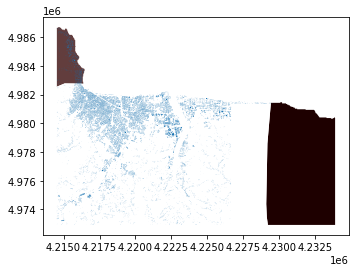

In [146]:
ax = Cities["Ordu"].vector["base_map"].geo_df.plot(column = "population", cmap="pink")
Cities["Ordu"].vector["MS"].geo_df.plot(ax=ax)

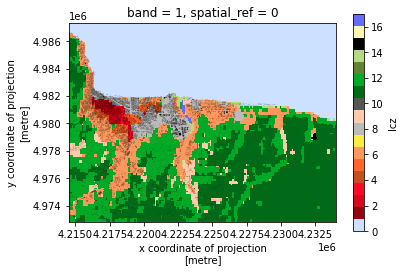

In [147]:
ax =Cities["Ordu"].vector["MS"].geo_df.plot(zorder=999, color="k")
Cities["Ordu"].raster["lcz"].tiff.lcz.plot(cmap=lcz_cmap, ax=ax)

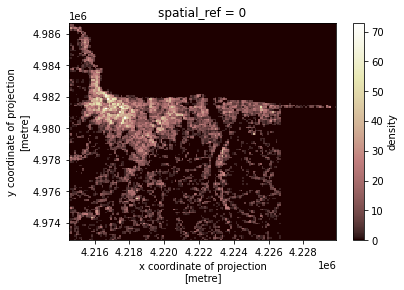

In [148]:
Cities["Ordu"].raster["MS_raster_100"].tiff.density.plot(cmap="pink")

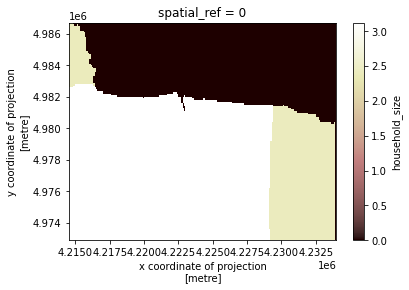

In [149]:
Cities["Ordu"].raster["census_raster_100"].tiff.household_size.plot(cmap="pink")